In [1]:
import tkinter as tk
import pandas as pd
from tkinter import filedialog, ttk
from sklearn import metrics
from sklearn.linear_model  import LinearRegression , Ridge ,ElasticNet ,Lasso
from sklearn.preprocessing import LabelEncoder ,PolynomialFeatures ,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import re
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import ast
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline
from joblib import dump, load


# data = pd.read_csv("hotel-classification-dataset.csv") 

# Handle nulls


In [2]:

def handle_nulls_in_train_data(train_data):
    fill_values = {}
    for column in train_data.columns:
        if train_data[column].dtype == 'object':
            fill_value = train_data[column].mode()
            fill_values[column] = fill_value
            train_data[column].fillna(fill_value, inplace=True)
        else:
            fill_value = train_data[column].median()
            fill_values[column] = fill_value
            train_data[column].fillna(fill_value, inplace=True)
    return train_data, fill_values

def handle_nulls_in_test_data(test_data, fill_values):
    for column in test_data.columns:
        if test_data[column].dtype == 'object':
            test_data[column].fillna(fill_values[column], inplace=True)
        else:
            test_data[column].fillna(fill_values[column], inplace=True)
    return test_data

# Load the training dataset
# train_data = pd.read_csv('train.csv')

# Preprocessing Functions 

## Get Date 

In [3]:
def change_date(data, col):
    data[col] = pd.to_datetime(data[col])
    data['year'] = data[col].dt.year.astype(float)
    data['month'] = data[col].dt.month.astype(float)
    data['day'] = data[col].dt.day.astype(float)
    data = data.drop(['Review_Date'],axis= 1 )
    return data 


## Get Address

In [4]:
def get_address(data):
    col =data['Hotel_Address']
    x=data['Hotel_Address'].str[-14:]
    data['Hotel_Address'] = data['Hotel_Address'].apply(lambda x: x.split()[-1])
    data['Hotel_Address'] =data['Hotel_Address'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
    data['Hotel_Address'] =data['Hotel_Address'].apply(lambda x: 'United States' if x == 'States' else x)
    return data 

## Get Days 

In [5]:
def get_daysNo(data):
    pattern = r'\d+'
    data['days_since_review'] = data['days_since_review'].apply(lambda x: int(re.findall(pattern, x)[0]))
    return data


## Get Tags

In [6]:
def get_tags(data):
  data['Tags'] = [ast.literal_eval(row) for row in data['Tags']]

  for index, row in data['Tags'].items():
    for name in row:
      if "trip" in name:
        data.at[index, 'Trip'] = name
      if ("room" in name.lower()) or ("suite" in name.lower()) or ("guestroom" in name.lower()) or ("studio" in name.lower()) or ("king" in name.lower()):
        data.at[index, 'Room'] = name
      if "night" in name:
        data.at[index, 'Nights'] = name
  data = data.drop('Tags', axis=1)
  return data


## Feature Encoding 

In [7]:
def Feature_Encoder(data, label, encoders=None):
    if encoders is None:
        encoders = {}
    
    cols = ('Hotel_Name', 'Reviewer_Nationality', 'Room', 'Trip', 'Nights', 'Hotel_Address', 'Positive_Review', 'Negative_Review')

    if label:
        for column in cols:
            if column in data.columns:
                encoders[column] = LabelEncoder()
                data[column] = encoders[column].fit_transform(data[column])
                print(f"Encoded column: {column}")
                print(encoders)
            else:
                print(f"Column '{column}' not found in the dataset.")
    else:
        for col in cols:
            if col in data.columns:
                if col in encoders:
                    new_values = data[col].unique()
                    unseen_values = np.setdiff1d(new_values.astype(str), encoders[col].classes_.astype(str))
                    if len(unseen_values) > 0:
                        encoders[col].classes_ = np.append(encoders[col].classes_, unseen_values)
                    data[col] = encoders[col].transform(data[col])
                else:
                    print(f"LabelEncoder not found for column '{col}'.")
            else:
                print(f"Column '{col}' not found in the test dataset.")

    return data, encoders


# Scaling Data

In [8]:
def scaler_fit_transform(X_train):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    # Save scaler object to disk
    dump(scaler, 'scaler.joblib')
    
    return X_train_scaled

def scaler_transform(X_test):
    # Load scaler object from disk
    scaler = load('scaler.joblib')
    
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    return X_test_scaled

# Load Data 

In [9]:
train_data = pd.read_csv('hotel-regression-dataset.csv')
def handle_duplicated(data):
    print(data.duplicated().sum())
    data = data.drop_duplicates()
    print(len(data))
    return data


train_data = handle_duplicated(train_data)
for i, col in enumerate(train_data.select_dtypes(include=['number']).columns):
    # axs[i, 0].scatter(data.index, data[col])
    # axs[i, 0].set_xlabel('Index')
    # axs[i, 0].set_ylabel(col)

    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)]
    train_data = train_data[(train_data[col] >= lower_bound) & (train_data[col] <= upper_bound)]



X = train_data.iloc[:, :-1]
Y = train_data['Reviewer_Score']

#Data Spliting 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'hotel-regression-dataset.csv'

# Preprocessing 

In [ ]:
def pre(data,fillvalues,encoder,label,test):
    if label:
        data = change_date(data,'Review_Date')
        print('done date')
        print('done nulls')
        data = get_address(data)
        print('done add')
        data = get_daysNo(data)
        print('done day')
        data = get_tags(data)
        print('done tags')
        data ,fill_values= handle_nulls_in_train_data(data)
        print('handel nulls done')
        print(data.info())
        data , encoders = Feature_Encoder(data, label=True)
        print('encoding done in train')
        print(data.info())
        data = scaler_fit_transform(data)

        return data ,fill_values,encoders

    else:
        if (test):  
            data = data.iloc[:, :-1]
            # y_test = data['Reviewer_Score'] 
            data = change_date(data,'Review_Date')
            print('done date')
            print('done nulls')
            data = get_address(data)
            print('done add')
            data = get_daysNo(data)
            print('done day')
            data = get_tags(data)
            print('done tags')
            data = handle_nulls_in_test_data(data, fillvalues)
            print(data.info())
            data ,_ = Feature_Encoder(data,label=False, encoders=encoder)
            print('done encoder in test')
            print(data.info())
        else:
            data = change_date(data,'Review_Date')
            print('done date')
            print('done nulls')
            data = get_address(data)
            print('done add')
            data = get_daysNo(data)
            print('done day')
            data = get_tags(data)
            print('done tags')
            data = handle_nulls_in_test_data(data, fillvalues)
            print(data.info())
            data ,_ = Feature_Encoder(data,label=False, encoders=encoder)
            print('done encoder in test')
            print(data.info())
            data = scaler_transform(data)


        return data
    

test = pd.read_csv('test.csv')

X_train,fillvalues ,encoders = pre(X_train,0,0,1,0)
X_test = pre(X_test,fillvalues,encoders,0,0)
test = pre(test,fillvalues,encoders,0,1)
        



done date
done nulls
done add
done day
done tags
handel nulls done
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127803 entries, 59548 to 221634
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               127803 non-null  object 
 1   Additional_Number_of_Scoring                127803 non-null  int64  
 2   Average_Score                               127803 non-null  float64
 3   Hotel_Name                                  127803 non-null  object 
 4   Reviewer_Nationality                        127803 non-null  object 
 5   Negative_Review                             127803 non-null  object 
 6   Review_Total_Negative_Word_Counts           127803 non-null  int64  
 7   Total_Number_of_Reviews                     127803 non-null  int64  
 8   Positive_Review                             127803 non-null  object 
 9  

## Models 

In [ ]:
print(X_train)

        Hotel_Address  Additional_Number_of_Scoring  Average_Score  \
0            1.000000                      0.193036       0.851852   
1            0.000000                      0.109765       0.296296   
2            1.000000                      0.149886       0.444444   
3            0.000000                      0.077214       0.629630   
4            1.000000                      0.177139       0.814815   
...               ...                           ...            ...   
127798       1.000000                      0.045420       0.703704   
127799       0.666667                      0.316427       0.407407   
127800       1.000000                      0.396669       0.407407   
127801       1.000000                      0.094625       0.703704   
127802       0.666667                      0.578350       0.481481   

        Hotel_Name  Reviewer_Nationality  Negative_Review  \
0         0.794824              0.949239         0.612345   
1         0.798521              0.949

In [ ]:
# X_train = X_train.drop(['lat','Total_Number_of_Reviews_Reviewer_Has_Given','lng','year','day','Reviewer_Nationality'],axis = 1)
# X_test = X_test.drop(['lat','Total_Number_of_Reviews_Reviewer_Has_Given','lng','year','day','Reviewer_Nationality'],axis = 1)

# models regression  

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pickle
import time


def regression_models(X_train, y_train, X_test, y_test):
    
    
    

    def LR():
        start = time.time()
        model = LinearRegression().fit(X_train, y_train)
        with open('linear_regression_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        end = time.time()
        training_time = end - start
        start1 = time.time()
        with open('linear_regression_model.pkl', 'rb') as file:
            lr_loaded = pickle.load(file)
        y_pred = lr_loaded.predict(X_test)
        y_train_pred=lr_loaded.predict(X_train)
        mse = mean_squared_error(y_test, y_pred)
        mse_train=mean_squared_error(y_train, y_train_pred)
        end1 = time.time()
        test_time = end1 - start1
        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE LR = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show()

        return mse,mse_train, training_time, test_time
    def Rd():
        start = time.time()
        model = Ridge(alpha=0.01).fit(X_train, y_train)
        with open('Ridge_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        end = time.time()
        training_time = end - start
        start1 = time.time()
        with open('Ridge_model.pkl', 'rb') as file:
            lr_loaded = pickle.load(file)
        y_pred = lr_loaded.predict(X_test)
        y_train_pred=lr_loaded.predict(X_train)
        mse = mean_squared_error(y_test, y_pred)
        mse_train=mean_squared_error(y_train, y_train_pred)
        end1 = time.time()
        test_time = end1 - start1
        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE Ridge = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show()   

        return mse,mse_train, training_time, test_time
   
    def poly():
        start = time.time()
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X_train)
        model = LinearRegression().fit(X_poly, y_train)
        with open('poly_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        end = time.time()
        training_time = end - start
        
        start1 = time.time()
        with open('poly_model.pkl', 'rb') as file:
            model_loaded = pickle.load(file)
        y_pred = model_loaded.predict(poly.transform(X_test))
        y_train_pred = model_loaded.predict(poly.transform(X_train))
        mse = mean_squared_error(y_test, y_pred)
        mse_train = mean_squared_error(y_train, y_train_pred)
        end1 = time.time()
        test_time = end1 - start1
        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE poly = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show()  
        return mse, mse_train, training_time, test_time
    def lasso():
        start = time.time()
        model = Lasso(alpha=0.001).fit(X_train, y_train)
        with open('lasso_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        end = time.time()
        training_time = end - start
        start1 = time.time()
        with open('lasso_model.pkl', 'rb') as file:
            lr_loaded = pickle.load(file)
        y_pred = lr_loaded.predict(X_test)
        y_train_pred=lr_loaded.predict(X_train)
        mse = mean_squared_error(y_test, y_pred)
        mse_train=mean_squared_error(y_train, y_train_pred)
        end1 = time.time()
        test_time = end1 - start1
        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE lasso & ploy = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show() 

        return mse,mse_train, training_time, test_time
    def Dt():
        start = time.time()
        model = DecisionTreeRegressor(random_state=50, max_depth=10).fit(X_train, y_train)
        with open('dtr_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        end = time.time()
        training_time = end - start
        start1 = time.time()
        with open('dtr_model.pkl', 'rb') as file:
            lr_loaded = pickle.load(file)
        y_pred = lr_loaded.predict(X_test)
        y_train_pred=lr_loaded.predict(X_train)
        mse = mean_squared_error(y_test, y_pred)
        mse_train=mean_squared_error(y_train, y_train_pred)
        end1 = time.time()
        test_time = end1 - start1
        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE Decision Tree = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show() 

        return mse,mse_train, training_time, test_time
    def RF():
        start = time.time()
        model = RandomForestRegressor( max_depth=10).fit(X_train, y_train)
        with open('rf_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        end = time.time()
        training_time = end - start
        start1 = time.time()
        with open('rf_model.pkl', 'rb') as file:
            lr_loaded = pickle.load(file)
        y_pred = lr_loaded.predict(X_test)
        y_train_pred=lr_loaded.predict(X_train)
        mse = mean_squared_error(y_test, y_pred)
        mse_train=mean_squared_error(y_train, y_train_pred)
        end1 = time.time()
        test_time = end1 - start1
        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE Random Forest  = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show() 

        return mse,mse_train, training_time, test_time
           
    def ploy_with_lasso():
        model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('lasso', Lasso(alpha=0.001))])

        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Generate predictions from the model for the testing data
        y_pred = model.predict(X_test)

        # Calculate the mean squared error of the model on the testing data
        mse = mean_squared_error(y_test, y_pred)
        print('Mean squared error of lasso & ploy: {:.2f}'.format(mse))

        plt.scatter(y_test, y_pred)
        plt.plot(np.arange(3, 14), np.arange(3, 14), color='r', linestyle='--')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title('MSE lasso & ploy = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
        plt.show() 
        
        return mse 

    return {
        "LR": LR(),
        "Rd": Rd(),
        "poly": poly(),
        "lasso": lasso(),
        "Decision": Dt(),
         "Random": RF(),
         "poly&lasso":ploy_with_lasso()
    }

# Ploting 

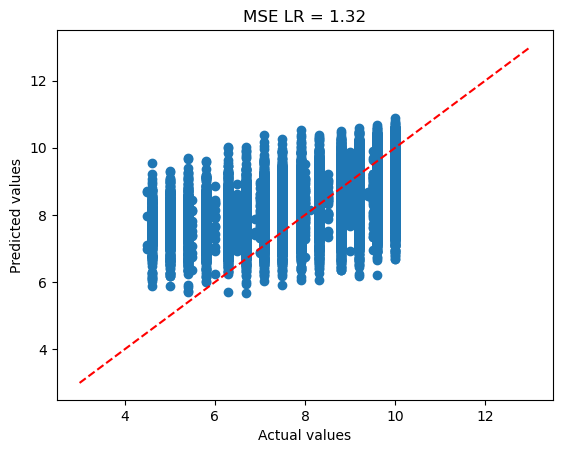

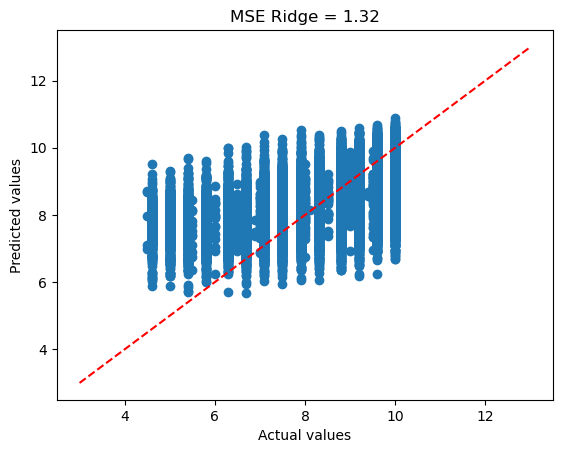

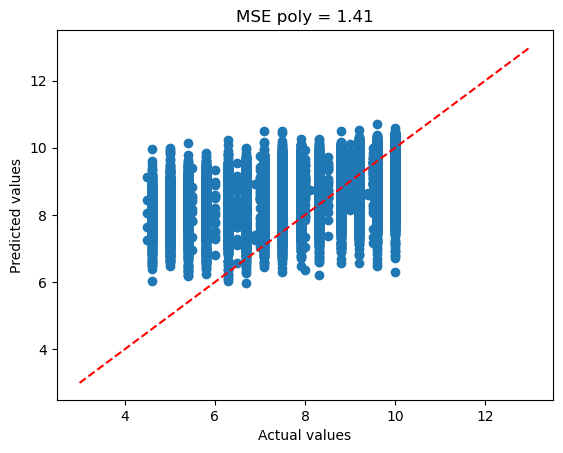

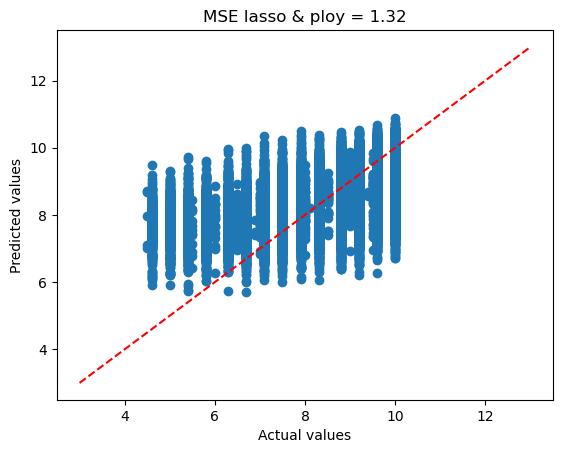

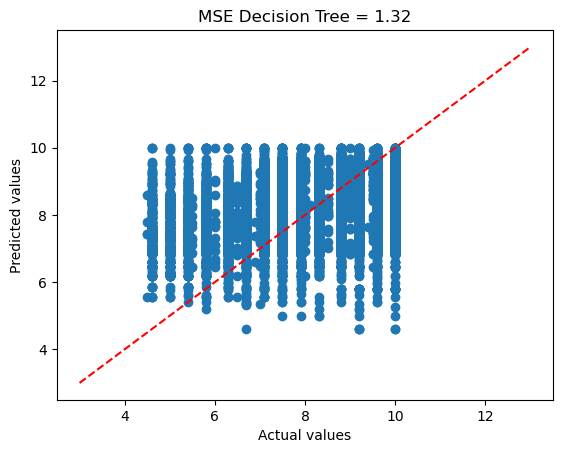

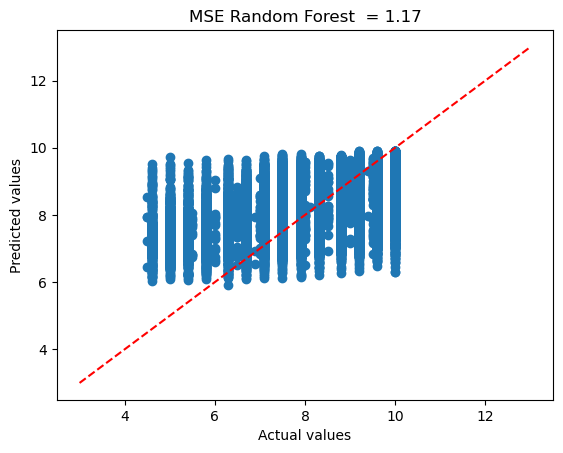

In [ ]:
results = regression_models(X_train, y_train, X_test, y_test)
# Extract the MSE values for each model
# mse_lr = results["LR"]
mse_lr_test,mse_lr_train,trainning_time_lr,testing_time_lr=results["LR"]
mse_rd_test,mse_rd_train,trainning_time_rd,testing_time_rd = results["Rd"]
mse_poly_test,mse_poly_train,trainning_time_poly,testing_time_poly = results["poly"]
mse_lasso_test,mse_lasso_train,trainning_time_lasso,testing_time_lasso = results["lasso"]
mse_Decision_test,mse_Decision_train,trainning_time_Decision,testing_time_Decision= results["Decision"]
mse_random_test,mse_random_train,trainning_time_random,testing_time_random = results["Random"]



# Print the MSE for each model for test data
print("-----------------------------------")
print("Linear Regression MSE for test data:", mse_lr_test)
print("-----------------------------------")
print("Ridge Regression MSE for test data:", mse_rd_test)
print("-----------------------------------")
print("Polynomial Regression MSE for test data:", mse_poly_test)
print("-----------------------------------")
print("Lasso Regression MSE for test data:",mse_lasso_test)
print("-----------------------------------")
print("Decision tree MSE for test data:", mse_Decision_test)
print("-----------------------------------")
# Print the MSE for each model for train data
print("-----------------------------------")
print("Linear Regression MSE for train data:", mse_lr_train)
print("-----------------------------------")
print("Ridge Regression MSE for train data:", mse_rd_train)
print("-----------------------------------")
print("Polynomial Regression MSE for train data:", mse_poly_train)
print("-----------------------------------")
print("Lasso Regression MSE for train data:",mse_lasso_train)
print("-----------------------------------")
print("Decision tree MSE for train data:", mse_Decision_train)
print("-----------------------------------")
# Print the time for each model for training data
print("-----------------------------------")
print(f"Linear Regression Training Time:  (Time: {trainning_time_lr:.2f} seconds)")
print("-----------------------------------")
print(f"Ridge Regression Training Time:  (Time: {trainning_time_rd:.2f} seconds)")
print("-----------------------------------")
print(f"Polynomial Regression Training Time:  (Time: {trainning_time_poly:.2f} seconds)")
print("-----------------------------------")
print(f"Lasso Regression Training Time:  (Time: {trainning_time_lasso:.2f} seconds)")
print("-----------------------------------")
print(f"Decision Regression Training Time:  (Time: {trainning_time_Decision:.2f} seconds)")
print("-----------------------------------")
# Print the time for each model for test data
print("-----------------------------------")
print(f"Linear Regression Testing Time:  (Time: {testing_time_lr:.2f} seconds)")
print("-----------------------------------")
print(f"Ridge Regression Testing Time:  (Time: {testing_time_rd:.2f} seconds)")
print("-----------------------------------")
print(f"Polynomial Regression Testing Time:  (Time: {testing_time_poly:.2f} seconds)")
print("-----------------------------------")
print(f"Lasso Regression Testing Time:  (Time: {testing_time_lasso:.2f} seconds)")
print("-----------------------------------")
print(f"Decision Regression Testing Time:  (Time: {testing_time_Decision:.2f} seconds)")
print("-----------------------------------")
import matplotlib.pyplot as plt



# Define the models and their corresponding MSE values for test data
models = ['Linear Regression', 'Ridge Regression', 'Polynomial Regression', 'Lasso Regression', 'Decision Tree']
mse_values = [mse_lr_test, mse_rd_test, mse_poly_test, mse_lasso_test, mse_Decision_test]

# Set the width of the bars
bar_width = 0.35

# Create a numpy array for the x-axis positions of the bars
x_pos = range(len(models))

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the bars
bars = ax.bar(x_pos, mse_values, bar_width)

# Add labels, title, and legend
ax.set_xlabel('Regression Models')
ax.set_ylabel('Mean Squared Error For Test Data')
ax.set_title('Comparison of Regression Models')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.show()

# Define the models and their corresponding MSE values for train data
models = ['Linear Regression', 'Ridge Regression', 'Polynomial Regression', 'Lasso Regression', 'Decision Tree']
mse_values = [mse_lr_train, mse_rd_train, mse_poly_train, mse_lasso_train, mse_Decision_train]

# Set the width of the bars
bar_width = 0.35

# Create a numpy array for the x-axis positions of the bars
x_pos = range(len(models))

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the bars
bars = ax.bar(x_pos, mse_values, bar_width)

# Add labels, title, and legend
ax.set_xlabel('Regression Models')
ax.set_ylabel('Mean Squared Error For Train Data')
ax.set_title('Comparison of Regression Models')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.show()

##########################################
# Define the time of test data and train data 
n_groups = 5
means_frank = (trainning_time_lr, trainning_time_rd, trainning_time_poly, trainning_time_lasso, trainning_time_Decision)
means_guido = (testing_time_lr, testing_time_rd, testing_time_poly, testing_time_lasso, testing_time_Decision)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Training Time')

rects2 = ax.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Testing Time')

ax.set_xlabel('Model')
ax.set_ylabel('Time (s)')
ax.set_title('Training and Testing Time by Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('LinearR', 'Ridge', 'Poly', 'Lasso', 'Decision'))
ax.legend()

fig.tight_layout()
plt.show()